In [19]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob
import subprocess as s
warnings.filterwarnings("ignore")

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from scipy.optimize import curve_fit



In [ ]:
def plotting(x, y, y_err, model, xlim, ObsID, instrument, figures_path,  xscale='linear', bkg=False):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.tick_params(direction='in', which='both', length=5, labelsize=15)
    ax2.tick_params(direction='in', which='both', length=5, labelsize=15)

    plt.suptitle('RATE')
    
    ax1.set_ylabel(r'N', fontsize = 15.0)
    ax1.set_xscale(xscale)
    
    ax1.set_xlim(0, xlim[1])

    ax1.errorbar(x, y, yerr=y_err, fmt='o', capsize=2, label='Data')
    ax1.plot(x, model, label='Fit')
    ax1.legend(loc='best', fontsize=15.0)

    ax2.set_ylabel(r'Ratio', fontsize = 15.0)
    ax2.set_ylim(0.5,1.5)
    ax2.axhline(y=1.)

    ax2.errorbar(x, y/model, yerr=y_err/model, fmt='o', capsize=2)

    ax2.set_xlabel('Rate [cts/s]', fontsize = 15.0)

    plt.subplots_adjust(hspace=0.1)
    
    # if not bkg:
    #     plt.savefig(figures_path+f'{ObsID}_{instrument}_rate_fit.png', bbox_inches='tight')
    # else:
    #     plt.savefig(figures_path+f'{instrument}_bkg_rate_fit.png', bbox_inches='tight')
    
    plt.show()
    
def fit(fname, path, PN_cts_limit = 15, EMOS_cts_limit = 15, PLOT=True):
    os.chdir(path)

    hdul = fits.open(fname)
    data = hdul[1].data

    time = data['time']
    rate = data['rate']
    rate_err = data['error']

    hdul.close()
    
    # Delete zero rates
    where = np.where(rate == 0)[0]

    time = np.delete(time, where)
    rate = np.delete(rate, where)
    rate_err = np.delete(rate_err, where)
    # filter maximum counts rate before fitting
    if('pn' in fname or 'oot' in fname):
        where = np.where(rate > PN_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)
            
    else:
        where = np.where(rate > EMOS_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)


    # Make histogram
    hist, bin_edges = np.histogram(np.log10(rate), bins=20)
        
    bin_mid = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_mid = 10**(bin_mid)
    hist_err = np.sqrt(hist)
    
    # Define gaussian function
    gaussian = lambda x, amp, cen, sig: amp * np.exp(-(x-cen)**2 / sig**2)
    
    where = np.where(hist_err == 0)[0]

    bin_mid = np.delete(bin_mid, where)
    hist = np.delete(hist, where)
    hist_err = np.delete(hist_err, where)
    
    # Fit
    init_vals = [max(hist), np.mean(bin_mid), np.std(hist_err)]
    
    best_vals, covar = curve_fit(gaussian, bin_mid, hist, p0=init_vals, sigma=1/hist_err, bounds=((0, 0, 0),
                                                                                        (np.inf, np.inf, np.inf)),
                                maxfev=100000)
    
    if PLOT == True:
        print(best_vals[1],best_vals[2])
        plotting(bin_mid, hist, hist_err, gaussian(bin_mid, *best_vals), 
                    [best_vals[1]-2*best_vals[2], best_vals[1]+2*best_vals[2]], 201, 
                    fname, figures_path='./', bkg=True)
        

        # check with the original lightcurve data
        plt.figure(figsize = (8,8))
        plt.scatter(data['time'],data['rate'])#, yerr=dat['ERROR'])
        
        plt.axhline(best_vals[1]+best_vals[2], color = 'r')
        plt.axhline(best_vals[1]+1.5*best_vals[2], color = 'r')
        plt.axhline(best_vals[1]+2*best_vals[2], color = 'r')
        plt.title(f'{fname}')
        plt.show()
    return best_vals[1], best_vals[2]



# 1. basic setting

In [2]:
'''
export SAS_CCF=/stage/headat/yanling/xmm/0502020201/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020201/1378_0502020101_SCX00000SUM.SAS

export SAS_CCF=/stage/headat/yanling/xmm/0502020101/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020101/1378_0502020101_SCX00000SUM.SAS

'''
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'


# 2. extract lightcurve of the background


In [ ]:
def bkg_lc(fname, analysis_path):
    os.chdir(analysis_path)
    # Check which instrument is requested and process accordingly
    if('pn' in fname):
        inst = 'EP'
        pattern = 4
    else:
        inst = 'EM'
        pattern = 12
    
    print(f'evselect table={fname}.fits.gz withrateset=Y rateset=rate_{fname}_bkg.fits \
        maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{inst} && (PI in [9000:12000]) && (PATTERN<={pattern})"')
    f.write(f'evselect table={fname}.fits.gz withrateset=Y rateset=rate_{fname}_bkg.fits \
        maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{inst} && (PI in [9000:12000]) && (PATTERN<={pattern})"')
    

files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
f = open(f'{bkg_dir}/bkg_lc.sh', 'w')
for fname in files:
    bkg_lc(fname, bkg_dir) 
f.close()


plot lightcone

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']

hdul = fits.open(f'rate_{files[0]}_bkg.fits')
dat = hdul[1].data
hdul.close()
plt.figure(figsize = (8,8))
plt.scatter(dat['TIME'],dat['RATE'])#, yerr=dat['ERROR'])
plt.axhline(0.35, color = 'r')
plt.show()

# 3. fit gaussian of bkg data

In [ ]:
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']

for file in files:
    fit(f'rate_{file}_bkg.fits', './', PN_cts_limit = 3, EMOS_cts_limit = 0.6,)

# 4. filter bkg data based on gaussian fitting results

In [47]:
# Keep log file 
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)

files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
f = open('bkg_gti.sh', 'w')
for file in files:    
        # Create GTI and filter
        fname = f'rate_{file}_bkg.fits'
        mean, sigma = fit(fname, bkg_dir, PN_cts_limit = 3, EMOS_cts_limit = 0.6, PLOT=False)
        print(f'tabgtigen table={fname} expression="RATE<={mean+2*sigma}" gtiset={file}_bkg_gti.fits')
        f.write(f'tabgtigen table={fname} expression="RATE<={mean+2*sigma}" gtiset={file}_bkg_gti.fits')
f.close()

f = open('bkg_clean.sh', 'w')
for file in files:
        if 'mos' in file:
                ins = 'EM'
        
        else:
                ins = 'EP'
        print(f'evselect table={file}.fits.gz withfilteredset=Y filteredset={file}_bkg_clean.fits destruct=Y \
                keepfilteroutput=T expression="gti({file}_bkg_gti.fits,TIME)&&(PI>150)"')
        f.write(f'evselect table={file}.fits.gz withfilteredset=Y filteredset={file}_bkg_clean.fits destruct=Y \
                keepfilteroutput=T expression="gti({file}_bkg_gti.fits,TIME)&&(PI>150)"')
f.close()
                

tabgtigen table=rate_mos1_closed_FF_2022_v2_bkg.fits expression="RATE<=0.33894348390483187" gtiset=mos1_closed_FF_2022_v2_bkg_gti.fits
tabgtigen table=rate_mos2_closed_FF_2022_v2_bkg.fits expression="RATE<=0.4398252665694047" gtiset=mos2_closed_FF_2022_v2_bkg_gti.fits
tabgtigen table=rate_pn_closed_EFF_2022_v2_bkg.fits expression="RATE<=1.0568921852852617" gtiset=pn_closed_EFF_2022_v2_bkg_gti.fits
tabgtigen table=rate_pn_closed_EFF_oot_2022_v2_bkg.fits expression="RATE<=1.1206854926795056" gtiset=pn_closed_EFF_oot_2022_v2_bkg_gti.fits
evselect table=mos1_closed_FF_2022_v2.fits.gz withfilteredset=Y filteredset=mos1_closed_FF_2022_v2_bkg_clean.fits destruct=Y                 keepfilteroutput=T expression="gti(mos1_closed_FF_2022_v2_bkg_gti.fits,TIME)&&(PI>150)"
evselect table=mos2_closed_FF_2022_v2.fits.gz withfilteredset=Y filteredset=mos2_closed_FF_2022_v2_bkg_clean.fits destruct=Y                 keepfilteroutput=T expression="gti(mos2_closed_FF_2022_v2_bkg_gti.fits,TIME)&&(PI>150)"
e

# 5. scale counts rate of bkg at 9-12 keV from clean file

extract high energies from bkg clean event files

In [51]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
# after 2005, loss of emos1 ccd should be included
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']

f = open('bkg_oofov_9-12_oofov_img.sh', 'w')
for file in files:
    if ('pn' in file):
        pattern = 4
        command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits \
            destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"'
        print(command)
        f.write(command)
    else:
        pattern = 12
        if ('mos1' in file):
            command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                    &&(CCDNR.ne.6)"'
            print(command)
            f.write(command)
        else:
            command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"' #&&region({region_file})
            print(command)
            f.write(command)

    command = f'evselect table={file}_bkg_clean_9-12_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize \
        ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_bkg_clean_9-12_oofov_img.fits'
    print(command)
    f.write(command)

f.close()
    


evselect table=mos1_closed_FF_2022_v2_bkg_clean.fits withfilteredset=Y filteredset=mos1_closed_FF_2022_v2_bkg_clean_9-12_oofov.fits destruct=Y                     keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<=12)&&(PI in [9000:12000])                    &&(CCDNR.ne.6)"
evselect table=mos1_closed_FF_2022_v2_bkg_clean_9-12_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize         ximagebinsize=20 yimagebinsize=20 withimageset=true imageset=mos1_closed_FF_2022_v2_bkg_clean_9-12_oofov_img.fits
evselect table=mos2_closed_FF_2022_v2_bkg_clean.fits withfilteredset=Y filteredset=mos2_closed_FF_2022_v2_bkg_clean_9-12_oofov.fits destruct=Y                     keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<=12)&&(PI in [9000:12000])"
evselect table=mos2_closed_FF_2022_v2_bkg_clean_9-12_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize         ximagebinsize=20 yimagebinsize=20 withimageset=true imageset=mos2_closed_FF_2022_v2_bkg_clean_9-12_oofov_img.fits
evselect table=pn_closed_EFF

Calculate background counts


In [53]:
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
os.chdir(bkg_dir)

f = open(f'{bkg_dir}/bkg_counts.log', 'w')
bkg_counts_list = np.zeros(len(files))
bkg_livetime_list = np.zeros(len(files))
for i, file in enumerate(files):
    fname = f'{file}_bkg_clean_9-12_oofov_img.fits'
    hdul = fits.open(fname)
    data = hdul[0].data
    bkg_counts = np.sum(data)
    hdul.close()

    # Read livetime for bkg
    fname = f'{file}_bkg_clean.fits'
    hdul = fits.open(fname)
    data = hdul[1].header
    bkg_livetime = data['LIVETI02']
    hdul.close()
    bkg_counts_list[i] = bkg_counts
    bkg_livetime_list[i] = bkg_livetime
    print(file, bkg_counts, bkg_livetime, bkg_counts/bkg_livetime)
    f.write(f'file, bkg_counts, bkg_livetime, bkg_counts/bkg_livetime')
    f.write(f'{file}, {bkg_counts}, {bkg_livetime}, {bkg_counts/bkg_livetime}')
f.close()


mos1_closed_FF_2022_v2 125161 1886442.17854285 0.06634764713365265
mos2_closed_FF_2022_v2 152663 1859701.47908783 0.08209005677345596
pn_closed_EFF_2022_v2 51401 739987.328768998 0.06946200022844697
pn_closed_EFF_oot_2022_v2 46518 740268.032837234 0.0628394013202352


extract clean events and images from observation files

In [54]:
data_dir = '/stage/headat/yanling/xmm/reduction_230227/101'
os.chdir(data_dir)
files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f = open(f'{data_dir}/data_oofov_9-12_oofov_img.sh', 'w')

for file in files:
    if (file=='EPN') or (file=='Oot'):
        pattern=4
        print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits \
        destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"') #"#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"
        print(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
        f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits \
        destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"')
        f.write(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
    else:
        pattern = 12
        if 'MOS1' in file:
            print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                    &&(CCDNR.ne.6)"') # &&region({region_file})
            f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                &&(CCDNR.ne.6)"')
        else:
            print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])') # &&region({region_file})
            f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"')
        
        print(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
        f.write(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
f.close()


evselect table=EMOS1_clean.fits withfilteredset=Y filteredset=EMOS1_oofov_clean.fits destruct=Y                     keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<=12)&&(PI in [9000:12000])                    &&(CCDNR.ne.6)"
evselect table=EMOS1_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize             ximagebinsize=20 yimagebinsize=20 withimageset=true imageset=EMOS1_oofov_counts.img
evselect table=EMOS2_clean.fits withfilteredset=Y filteredset=EMOS2_oofov_clean.fits destruct=Y                     keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<=12)&&(PI in [9000:12000])
evselect table=EMOS2_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize             ximagebinsize=20 yimagebinsize=20 withimageset=true imageset=EMOS2_oofov_counts.img
evselect table=EPN_clean.fits withfilteredset=Y filteredset=EPN_oofov_clean.fits         destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<=4)&&(PI in [9000:12000])"
evselect table=EPN_oofov_clean.fits xcolumn=X yco

read data counts

In [81]:
# Read the counts
data_dir = '/stage/headat/yanling/xmm/reduction_230227/201'
os.chdir(data_dir)
f = open(f'{data_dir}/data_oofov_counts.log', 'w')

files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
obs_counts_list = np.zeros(len(files))
obs_livetime_list = np.zeros(len(files))
for i, instrument in enumerate(files):
    fname = glob.glob(instrument + '_oofov_*.img')[0]
    hdul = fits.open(fname)
    data = hdul[0].data

    obs_counts = np.sum(data)

    hdul.close()

    # Read livetime for source
    fname = instrument + '_clean.fits'
    hdul = fits.open(fname)
    data = hdul[1].header

    obs_livetime = data['LIVETI02']

    hdul.close()
    print(instrument, obs_counts, obs_livetime, obs_counts/obs_livetime)
    f.write('instrument, obs_counts, obs_livetime, obs_counts/obs_livetime')
    f.write(f'{instrument}, {obs_counts}, {obs_livetime}, {obs_counts/obs_livetime}')
    obs_counts_list[i] = obs_counts
    obs_livetime_list[i] = obs_livetime
f.close()

'''oofov area 
bkg
mos1_closed_FF_2022_v2 125161 1886442.17854285 0.06634764713365265
mos2_closed_FF_2022_v2 136006 1859701.47908783 0.07313324290450635
pn_closed_EFF_2022_v2 39345 739987.328768998 0.053169829361067796
pn_closed_EFF_oot_2022_v2 35303 740268.032837234 0.04768948331416362
101 obs 
EMOS1 3360 39004.5795996189 0.08614373067189345
EMOS2 4230 46478.1277415752 0.09101055067276771
EPN 1339 15959.1501955055 0.08390171052949275
Oot 1116 14977.9862565659 0.07450934864563513
'''
obs_counts_list = np.array(obs_counts_list)
obs_livetime_list = np.array(obs_livetime_list)
bkg_counts_list = np.array(bkg_counts_list)
bkg_livetime_list = np.array(bkg_livetime_list)
f = open(f'{bkg_dir}/bkg_oofov_9-12_ratio_counts.log', 'w')
f.write('instrument, ctr ratio, cts ratio')
f.write(f'{instrument},{(obs_counts_list/obs_livetime_list)/(bkg_counts_list/bkg_livetime_list)}, {(obs_counts_list)/(bkg_counts_list)}')
f.close()
print('ctr ratio:', (obs_counts_list/obs_livetime_list)/(bkg_counts_list/bkg_livetime_list), 'cts ratio:', (obs_counts_list)/(bkg_counts_list))

EMOS1 3585 42168.3808472157 0.08501630672017398
EMOS2 4378 44494.2199368477 0.09839480288032598
EPN 2173 26172.2461067066 0.0830268824135492
Oot 2103 26664.291492641 0.07886952483175488
ctr ratio: [1.28137636 1.19862023 1.19528493 1.25509669] cts ratio: [0.02864311 0.02867754 0.04227544 0.04520831]


# 6. Generate scaled bkg cts image

Reproject background events 

In [29]:
'''
attra=24.429 attdec=-12.870 attapos=-60.977
attra=24.409 attdec=-12.943 attapos=-59.440
'''
f = open(f'{bkg_dir}/bkg_reproj_evt.sh', 'w')
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
# files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
files = ['mos2_closed_FF_2022_v2']
ralist = [24.409, 24.429]
declist = [-12.943, -12.870]
palist = [59.440, 60.977]

for j in range(2):
        obs = f'{j+1}01'
        ra = ralist[j]; dec = declist[j]; pa = palist[j]
        for i in range(len(files)):
                os.system(f'cp {files[i]}_bkg_clean.fits {files[i]}_obs{obs}_bkg_clean.fits')
                print(f'evproject eventset={files[i]}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}')
                f.write(f'cp {files[i]}_bkg_clean.fits {files[i]}_obs{obs}_bkg_clean.fits\n')
                f.write(f'evproject eventset={files[i]}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}\n')

f.close()


evproject eventset=mos2_closed_FF_2022_v2_obs101_bkg_clean.fits attsource=fixed attra=24.409 attdec=-12.943 attapos=59.44
evproject eventset=mos2_closed_FF_2022_v2_obs201_bkg_clean.fits attsource=fixed attra=24.429 attdec=-12.87 attapos=60.977


extract and scale the bkg images

In [2]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
scales_dir = {'101':[0.02684542, 0.02770809, 0.02605008, 0.02399071], 
    '201':[0.02864311, 0.02867754, 0.04227544, 0.04520831]}
os.chdir(bkg_dir)

for obs in [101, 201]:
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]

        scales = scales_dir[str(obs)]
        f = open(f'{bkg_dir}/bkg_img_obs{obs}_{blo}-{bhi}.sh', 'w')
        for i, file in enumerate(files):
            evtfile = f'{file}_obs{obs}_bkg_clean'
            imgfile = f'{evtfile}_{blo}-{bhi}'
            if ('pn' in file):
                ins = 'EP'
                pattern = 4
                print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"')
                f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
            else:
                ins = 'EM'
                pattern = 12
                if 'mos1' in file:
                    print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)"')
                    f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)"\n')
                else:
                    print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})\n"')
                    f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
            
            print(f'farith {imgfile}.img {scales[i]} {imgfile}_scaled.img "*" clobber=yes')
            f.write(f'farith {imgfile}.img {scales[i]} {imgfile}_scaled.img "*" clobber=yes\n')
        f.close()

evselect table=mos1_closed_FF_2022_v2_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=true imageset=mos1_closed_FF_2022_v2_obs101_bkg_clean_700-1200.img expression="#XMMEA_EM&&(PATTERN<=12)&&(PI>=700)&&(PI<=1200)&&(CCDNR.ne.6)"
farith mos1_closed_FF_2022_v2_obs101_bkg_clean_700-1200.img 0.02684542 mos1_closed_FF_2022_v2_obs101_bkg_clean_700-1200_scaled.img "*" clobber=yes
evselect table=mos2_closed_FF_2022_v2_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=true imageset=mos2_closed_FF_2022_v2_obs101_bkg_clean_700-1200.img expression="#XMMEA_EM&&(PATTERN<=12)&&(PI>=700)&&(PI<=1200)
"
farith mos2_closed_FF_2022_v2_obs101_bkg_clean_700-1200.img 0.02770809 mos2_closed_FF_2022_v2_obs101_bkg_clean_700-1200_scaled.img "*" clobber=yes
evselect table=pn_closed_EFF_2022_v2_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withi

manage pn image (substract oot data)

In [4]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
f = open('bkg_pn_oot_corr.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
      blo = band.split('-')[0]
      bhi = band.split('-')[1]
      frame = 'eff'
      # Scale OoT image
      for obs in [101,201]:
            pn_imgname = f'pn_closed_EFF_2022_v2_obs{obs}_bkg_clean_{blo}-{bhi}_scaled'
            oot_imgname = f'pn_closed_EFF_oot_2022_v2_obs{obs}_bkg_clean_{blo}-{bhi}_scaled'
            if(frame == 'eff'):
                  print(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes\n')
                  
            elif(frame == 'ff'):
                  print(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes\n')

            print(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes')
            f.write(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes\n')
f.close()

farith pn_closed_EFF_oot_2022_v2_obs101_bkg_clean_700-1200_scaled.img 0.023 pn_closed_EFF_oot_2022_v2_obs101_bkg_clean_700-1200_scaled_corr.img MUL clobber=yes
farith pn_closed_EFF_2022_v2_obs101_bkg_clean_700-1200_scaled.img pn_closed_EFF_oot_2022_v2_obs101_bkg_clean_700-1200_scaled_corr.img pn_closed_EFF_2022_v2_obs101_bkg_clean_700-1200_scaled_corr.img SUB clobber=yes
farith pn_closed_EFF_oot_2022_v2_obs201_bkg_clean_700-1200_scaled.img 0.023 pn_closed_EFF_oot_2022_v2_obs201_bkg_clean_700-1200_scaled_corr.img MUL clobber=yes
farith pn_closed_EFF_2022_v2_obs201_bkg_clean_700-1200_scaled.img pn_closed_EFF_oot_2022_v2_obs201_bkg_clean_700-1200_scaled_corr.img pn_closed_EFF_2022_v2_obs201_bkg_clean_700-1200_scaled_corr.img SUB clobber=yes
farith pn_closed_EFF_oot_2022_v2_obs101_bkg_clean_1200-2000_scaled.img 0.023 pn_closed_EFF_oot_2022_v2_obs101_bkg_clean_1200-2000_scaled_corr.img MUL clobber=yes
farith pn_closed_EFF_2022_v2_obs101_bkg_clean_1200-2000_scaled.img pn_closed_EFF_oot_2022_

check bkg images

(648, 648)


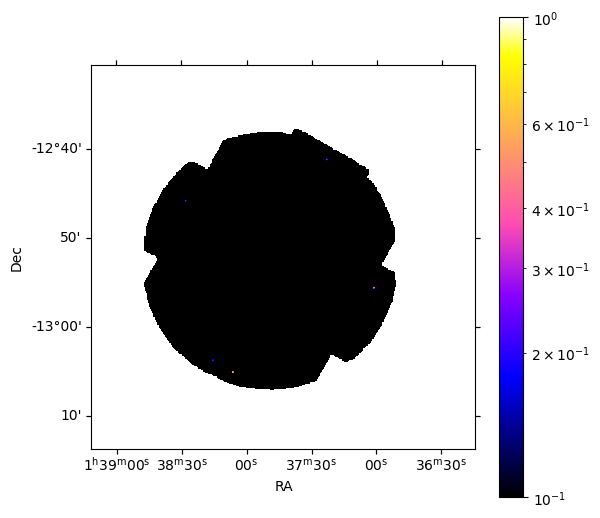

nan


<Figure size 640x480 with 0 Axes>

In [39]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=1)

file = f'{bkg_dir}/mos2_closed_FF_2022_v2_obs201_bkg_clean_700-1200_scaled'
# file = 'EPN_corr_counts'
hdu = fits.open(f'{file}.img')[0]
image_data = hdu.data
print(image_data.shape)
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}.img'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
'''
ra.set_ticks_visible(True)
dec.set_ticks_visible(True)
ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ra.set_ticks_position('all')
ra.set_ticks(number=4)
dec.set_ticks(number=4)
'''
image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
astropy_conv = convolve(image_data, kernel)
plt.imshow(astropy_conv, cmap='gnuplot2', norm = colors.LogNorm(vmin = 1e-1, vmax = 1), origin='lower')
plt.colorbar()
plt.savefig(f'{file}.png')
plt.show()
plt.clf()
print(np.min(np.log10(image_data[50:550,50:550])))